# **Step1: Business case:**
Three data sets are provided for the project. 
Claim Data (Dataset 1) – all claims that were found from a Loss History Report (LHR) at driver level (Only households with claims will appear in this dataset)

Predictor Dataset (Dataset 2) – all information we have from this household’s insurance application (Application date of January 1, 2017)

Subsequent Loss Experience (Dataset 3) – one year of subsequent loss-experience of these applicants (All information gathered after application date)

Metadata – Names and descriptions of the variables contained in each of the datasets listed above.


Objective:Create a model where you are trying to identify if the applicant had a future loss (future_clm_ind) using the information known on or before the application date.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xlrd
# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
# for modeling purpose
#!pip install scikit-learn 

# Step 2: Data collection/Acquisition: 
 3 seperate data set with informaton in xls format improted

In [2]:
# Load data sets
df_claim_raw=pd.read_excel('/content/Claim_Data.xlsm', sheet_name='Claim_Data')
df_predictor_raw=pd.read_excel('/content/Predictor Dataset.xlsm', sheet_name='Predictor_Data')
df_loss_raw=pd.read_excel('/content/Subsequent_Loss_Experience.xlsm',sheet_name='Subsequent_Loss_Experience')

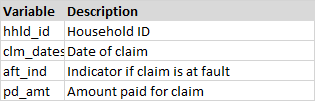

In [3]:
# Check data set 1- claim data 
df_claim_raw.head(10)

hhld_id  clm_dates  aft_ind   pd_amt
0        2 2015-03-07        0   112.02
1       12 2013-08-18        0     0.00
2       13 2016-04-06        1  6499.32
3       26 2011-06-27        0   221.36
4       26 2010-12-10        1     0.00
5       27 2013-07-03        0   233.49
6       29 2011-09-13        1  8022.33
7       36 2013-05-04        0   236.18
8       39 2010-03-08        0   192.98
9       48 2015-05-24        0     0.00

In [4]:
# Summary data
df_claim_raw.describe()
df_claim_raw.dtypes

hhld_id               int64
clm_dates    datetime64[ns]
aft_ind               int64
pd_amt              float64
dtype: object

In [5]:
# check missig values
df_claim_raw.isna().sum()

hhld_id      0
clm_dates    0
aft_ind      0
pd_amt       0
dtype: int64

# **Step3: Data preperation**
## **Client requriments : **

---
For this work sample: 
•	Please note, the criteria to count a claim is that it must have at **least one dollar paid** out and be prior to the Application** Date January 1, 2017.**

---
•	Use the indicator to know if the claim is an At Fault loss or Not At Fault loss. 


In [6]:
# check conditions and modify the df to satify the conditions
df_claim=df_claim_raw[(df_claim_raw['clm_dates' ] < '2017-01-01') & (df_claim_raw['pd_amt']>=1)]  # check for date condition
df_claim.shape

(4888, 4)

In [7]:
df_claim.sort_values(by=['clm_dates']) # sort data by dates with at least $ 1 paid and before 1/1/2017

hhld_id  clm_dates  aft_ind  pd_amt
1982     7904 2010-01-01        0  240.98
3636    14599 2010-01-01        0  169.53
760      3036 2010-01-01        0  270.99
3479    13942 2010-01-01        0  337.38
2641    10521 2010-01-02        0  293.41
...       ...        ...      ...     ...
1433     5729 2016-12-28        0  503.55
963      3857 2016-12-29        0  392.22
1629     6386 2016-12-29        0  336.64
921      3681 2016-12-30        0  238.31
4184    16835 2016-12-30        0  525.45

[4888 rows x 4 columns]

# **Data preperation steps:**
Step 1: from client dataset

Use the above datasets to: 
1.	Aggregate Dataset 1 at the hhld_id to create the following claim count variables:
•	Number of At Fault claims in each of the last 5 years from application date
•	Number of Not At Fault claims in each of the last 5 years from application date


In [8]:
# Count No of claims preior 5 years from  1/1/17 . So the  start date is 1/1/2012
df1 = df_claim[(df_claim["clm_dates"] > '2011-12-31')]
# Display btm 10 rows of dataset_1 sored by ID
df1.head()

hhld_id  clm_dates  aft_ind   pd_amt
0         2 2015-03-07        0   112.02
2        13 2016-04-06        1  6499.32
5        27 2013-07-03        0   233.49
7        36 2013-05-04        0   236.18
10       49 2014-09-13        0   475.18

In [9]:
#Method 2: first create two columns  based on aft_ind and make it integer
df1['atf_claim_no']=(df1['aft_ind']==1).astype('int')
df1['Not_atf_claim_no']=(df1['aft_ind']==0).astype('int')
df1.tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


hhld_id  clm_dates  aft_ind   pd_amt  atf_claim_no  Not_atf_claim_no
4989    19922 2014-05-22        0    98.51             0                 1
4990    19922 2015-01-17        0   234.20             0                 1
4991    19926 2016-12-03        0   171.92             0                 1
4992    19929 2013-06-30        0   397.97             0                 1
4993    19933 2016-09-22        0   199.15             0                 1
4995    19960 2013-09-26        0   412.23             0                 1
4996    19980 2015-01-07        1  9711.55             1                 0
4997    19991 2012-12-12        1  5715.19             1                 0
4998    19994 2015-12-27        1  6506.34             1                 0
4999    19997 2016-10-31        0   249.93             0                 1

In [10]:
# aft_ind split into to and no need to have aftind and date cols
#DF1=dataset_1.drop(columns=['aft_ind','clm_dates','pd_amt'])
#DF1=dataset_1
# Display btm 10 rows of dataset_1 sored by ID
df1.sort_values(by='hhld_id').tail(10)

hhld_id  clm_dates  aft_ind   pd_amt  atf_claim_no  Not_atf_claim_no
4989    19922 2014-05-22        0    98.51             0                 1
4990    19922 2015-01-17        0   234.20             0                 1
4991    19926 2016-12-03        0   171.92             0                 1
4992    19929 2013-06-30        0   397.97             0                 1
4993    19933 2016-09-22        0   199.15             0                 1
4995    19960 2013-09-26        0   412.23             0                 1
4996    19980 2015-01-07        1  9711.55             1                 0
4997    19991 2012-12-12        1  5715.19             1                 0
4998    19994 2015-12-27        1  6506.34             1                 0
4999    19997 2016-10-31        0   249.93             0                 1

In [11]:
#Method 2 to groupby hhld_id to count by col. 
DF2=df1.groupby(['hhld_id']).sum()
DF2.reset_index(inplace=True)
DF2.tail(10)

hhld_id  aft_ind   pd_amt  atf_claim_no  Not_atf_claim_no
3208    19919        0   356.49             0                 1
3209    19922        0   332.71             0                 2
3210    19926        0   171.92             0                 1
3211    19929        0   397.97             0                 1
3212    19933        0   199.15             0                 1
3213    19960        0   412.23             0                 1
3214    19980        1  9711.55             1                 0
3215    19991        1  5715.19             1                 0
3216    19994        1  6506.34             1                 0
3217    19997        0   249.93             0                 1

In [12]:
# aft_ind not needed 
DF2.drop(['aft_ind'],axis=1,inplace=True)
DF2.shape

(3218, 4)

In [13]:
#Trasnfer to a meaningful dataframe to use.
df_clmcount=DF2
df_clmcount.tail(10)

hhld_id   pd_amt  atf_claim_no  Not_atf_claim_no
3208    19919   356.49             0                 1
3209    19922   332.71             0                 2
3210    19926   171.92             0                 1
3211    19929   397.97             0                 1
3212    19933   199.15             0                 1
3213    19960   412.23             0                 1
3214    19980  9711.55             1                 0
3215    19991  5715.19             1                 0
3216    19994  6506.34             1                 0
3217    19997   249.93             0                 1

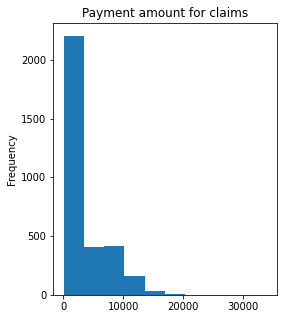

In [14]:
#Check range of payment ampout with histogram
df_clmcount['pd_amt'].plot(kind='hist',figsize=(4,5), title='Payment amount for claims')


In [15]:
# export to csv by giving meaningful name to the dataframe

df_clmcount.to_excel('\Claim count by aft indicator.xls')

In [16]:
# Download to local drive
df_clmcount.to_csv('\Claim_count_by_aft_indicator.csv')
from google.colab import files
files.download('\Claim_count_by_aft_indicator.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Data preperations:**
**part 2 data processing**
2.	Merge the Datasets 2 and 3, and the aggregated form of Dataset 1 using hhld_id

 **Predictor Dataset (Dataset 2)** – all information we have from this household’s insurance application (Application date of January 1, 2017).
---
**Subsequent Loss Experience (Dataset 3)** – one year of subsequent loss-experience of these applicants (All information gathered after application date)



In [17]:
# preprocessing of predictors dataset
df_predictor_raw.shape

(20000, 41)

In [18]:
df_predictor_raw.dtypes # type of tada in the dataset

hhld_id              int64
drvr_cnt             int64
veh_cnt              int64
min_age            float64
hoh_age            float64
max_age            float64
avg_age            float64
min_mon_lic        float64
hoh_mon_lic        float64
max_mon_lic        float64
avg_mon_lic        float64
cnt_yth              int64
cnt_female           int64
cnt_male             int64
cnt_married          int64
cnt_single           int64
hoh_married           bool
cnt_auto             int64
cnt_mtrcyc           int64
avg_majr_viol      float64
cnt_majr_viol        int64
cnt_minr_viol        int64
avg_minr_viol      float64
cnt_lic_susp         int64
curnt_insurer       object
time_w_carr        float64
inforce_ind          int64
prior_bi           float64
fire_ind             int64
homeowner_ind        int64
veh_lien_cnt       float64
veh_lease_cnt        int64
veh_own_cnt          int64
monthly_pay_ind      int64
veh_w_coll_cnt       int64
veh_w_comp_cnt       int64
veh_w_ers_cnt        int64
c

In [19]:
df_predictor_raw.isnull().sum() # check for missing values

hhld_id                0
drvr_cnt               0
veh_cnt                0
min_age                0
hoh_age                0
max_age                0
avg_age                0
min_mon_lic            0
hoh_mon_lic            0
max_mon_lic            0
avg_mon_lic            0
cnt_yth                0
cnt_female             0
cnt_male               0
cnt_married            0
cnt_single             0
hoh_married            0
cnt_auto               0
cnt_mtrcyc             0
avg_majr_viol          0
cnt_majr_viol          0
cnt_minr_viol          0
avg_minr_viol          0
cnt_lic_susp           0
curnt_insurer          0
time_w_carr         7010
inforce_ind            0
prior_bi            7010
fire_ind               0
homeowner_ind          0
veh_lien_cnt       19974
veh_lease_cnt          0
veh_own_cnt            0
monthly_pay_ind        0
veh_w_coll_cnt         0
veh_w_comp_cnt         0
veh_w_ers_cnt          0
curnt_bi_low           0
curnt_bi_upp           0
credit_score         921


In [20]:
df_predictor_raw.head(10)

hhld_id  drvr_cnt  veh_cnt  ...  curnt_bi_upp  credit_score  zipcode
0    15937         2        1  ...           100    825.949106    35741
1    13778         1        1  ...            25    684.650216    87884
2    16063         1        1  ...           100    596.318289    81525
3    12789         1        1  ...           100    636.757859    35741
4     5122         1        1  ...            50    669.569992    59792
5    10043         2        1  ...            25    789.850495    96391
6    19925         1        1  ...            25    563.682412    98013
7     6779         1        1  ...            25    614.322919    38912
8    16317         1        1  ...            25    579.998579    85767
9     1865         1        1  ...            25    724.107485    81525

[10 rows x 41 columns]

# Loss experience dataset: Meta data
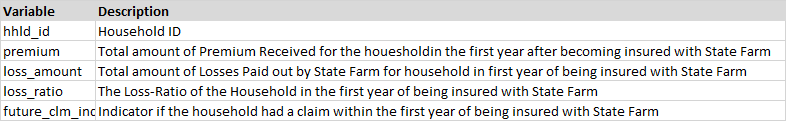

In [21]:
# Preprocessing - data set 3
df_loss_raw.dtypes

hhld_id             int64
premium           float64
pd_amt            float64
loss_ratio        float64
future_clm_ind      int64
dtype: object

**Note:** pmt_amt col already available in claim data set . Renameing it to match meta data

In [22]:
df_loss=df_loss_raw.rename(columns={'pd_amt':'loss_amt'})  # as per meta data loss amount for the one year 


In [23]:
df_loss.head(10) # check to make sure col name changed

hhld_id  premium  loss_amt  loss_ratio  future_clm_ind
0    15937   133.60       0.0         0.0               0
1    13778   145.80       0.0         0.0               0
2    16063   167.00       0.0         0.0               0
3    12789   150.30       0.0         0.0               0
4     5122   117.00       0.0         0.0               0
5    10043   133.60       0.0         0.0               0
6    19925   150.30       0.0         0.0               0
7     6779    94.50       0.0         0.0               0
8    16317   167.00       0.0         0.0               0
9     1865   120.24       0.0         0.0               0

In [24]:
df_loss.shape  # shape for both dataset 2 and 3 have 20k records


(20000, 5)

In [25]:
# Marge datast 2 and 3 based on 'hhld_id ' column. pred dataset will be 1 and loss wil be 2
df_combined_raw=pd.merge(df_predictor_raw,df_loss, on='hhld_id',how='outer')

In [26]:
# check to make sure new (5-1)= 4 cols added to the combined dataset
df_combined_raw.shape

(20000, 45)

In [27]:
df_combined_raw.head(5)

hhld_id  drvr_cnt  veh_cnt  ...  loss_amt  loss_ratio  future_clm_ind
0    15937         2        1  ...       0.0         0.0               0
1    13778         1        1  ...       0.0         0.0               0
2    16063         1        1  ...       0.0         0.0               0
3    12789         1        1  ...       0.0         0.0               0
4     5122         1        1  ...       0.0         0.0               0

[5 rows x 45 columns]

In [28]:
# Add claim count dataset ( transforemd in the 1st step) to the combined datset. As df_clmcount has only 3218 observations, 16% of the total 20k records.
#we will do joining to make sure all data are combined with outer join- similar to SQL
df_combined3_raw=pd.merge(df_combined_raw,df_clmcount, on = 'hhld_id', how='outer')

In [29]:
# Replace missing aft indictor values with 0 for hhld_Id that never had a claim as 84% will have NaN . This is boolean indicator. 0: no claim in both cases.
# Check double[]: The interior brackets are for list, and the outside brackets are indexing operator, i.e. must use double brackets for selecting two or more columns.
# With one column name, single pair of brackets returns a Series, while double brackets return a dataframe.
df_combined3_raw[['atf_claim_no',	'Not_atf_claim_no']]=df_combined3_raw[['atf_claim_no',	'Not_atf_claim_no']].fillna(0)

In [30]:
# view data frame - final shape has 48 features and 2000 records
df_combined3_raw.isna().sum()

hhld_id                 0
drvr_cnt                0
veh_cnt                 0
min_age                 0
hoh_age                 0
max_age                 0
avg_age                 0
min_mon_lic             0
hoh_mon_lic             0
max_mon_lic             0
avg_mon_lic             0
cnt_yth                 0
cnt_female              0
cnt_male                0
cnt_married             0
cnt_single              0
hoh_married             0
cnt_auto                0
cnt_mtrcyc              0
avg_majr_viol           0
cnt_majr_viol           0
cnt_minr_viol           0
avg_minr_viol           0
cnt_lic_susp            0
curnt_insurer           0
time_w_carr          7010
inforce_ind             0
prior_bi             7010
fire_ind                0
homeowner_ind           0
veh_lien_cnt        19974
veh_lease_cnt           0
veh_own_cnt             0
monthly_pay_ind         0
veh_w_coll_cnt          0
veh_w_comp_cnt          0
veh_w_ers_cnt           0
curnt_bi_low            0
curnt_bi_upp

# Predict data set: Meta data

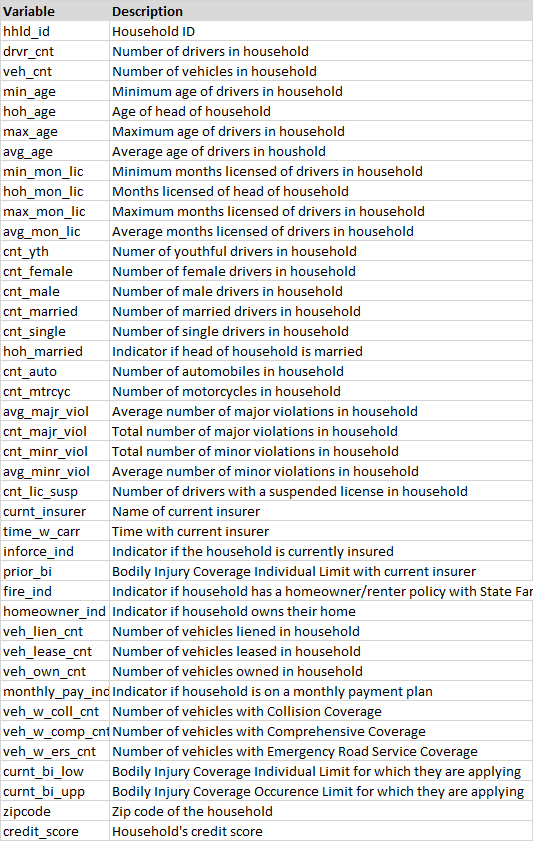

In [31]:
# Check for few rows 
df_combined3_raw.sort_values(by='hhld_id').tail(10)

hhld_id  drvr_cnt  veh_cnt  ...   pd_amt  atf_claim_no  Not_atf_claim_no
15211    19991         1        1  ...  5715.19           1.0               0.0
17555    19992         1        1  ...      NaN           0.0               0.0
10915    19993         1        1  ...      NaN           0.0               0.0
498      19994         3        1  ...  6506.34           1.0               0.0
8625     19995         2        2  ...      NaN           0.0               0.0
19847    19996         1        1  ...      NaN           0.0               0.0
10984    19997         1        2  ...   249.93           0.0               1.0
7772     19998         2        1  ...      NaN           0.0               0.0
3131     19999         4        2  ...      NaN           0.0               0.0
11244    20000         2        2  ...      NaN           0.0               0.0

[10 rows x 48 columns]

# **STEP 4: Vizualization and Exploratory data analysis (EDA) *
With pandas profiling and sweetviz packages for visualizations and EDA to identify noise variables,  missing values and daty types. **
Feature selection process that impact the oucome of the model- identify if an an applicant had a future loss claim

---



In [32]:
cols=list(df_combined3_raw.columns.values) # get the list of cols name to view and rearrage
#cols


In [33]:
#  Take response col to the rightof the data frame - future_clm_ind
df_combined3_raw=df_combined3_raw.reindex(columns=['hhld_id',
 'drvr_cnt', 'veh_cnt', 'min_age', 'hoh_age', 'max_age', 'avg_age', 'min_mon_lic',
 'hoh_mon_lic',  'max_mon_lic', 'avg_mon_lic',  'cnt_yth', 'cnt_female',
 'cnt_male', 'cnt_married', 'cnt_single', 'hoh_married', 'cnt_auto', 'cnt_mtrcyc',
 'avg_majr_viol', 'cnt_majr_viol', 'cnt_minr_viol', 'avg_minr_viol',
 'cnt_lic_susp', 'curnt_insurer', 'time_w_carr', 'inforce_ind',
 'prior_bi', 'fire_ind', 'homeowner_ind', 'veh_lien_cnt', 'veh_lease_cnt',
 'veh_own_cnt', 'monthly_pay_ind', 'veh_w_coll_cnt', 'veh_w_comp_cnt',
 'veh_w_ers_cnt', 'curnt_bi_low', 'curnt_bi_upp', 'credit_score',
 'zipcode', 'premium', 'loss_amt', 'loss_ratio', 'pd_amt',
 'atf_claim_no','Not_atf_claim_no', 'future_clm_ind'])
# Check to make sure response variable is the right most cols
df_combined3_raw.head(5)

hhld_id  drvr_cnt  veh_cnt  ...  atf_claim_no  Not_atf_claim_no  future_clm_ind
0    15937         2        1  ...           1.0               1.0               0
1    13778         1        1  ...           0.0               0.0               0
2    16063         1        1  ...           0.0               0.0               0
3    12789         1        1  ...           0.0               0.0               0
4     5122         1        1  ...           0.0               0.0               0

[5 rows x 48 columns]

In [34]:
# Start visulation and EDA
# Make a modeling dataframe for EDA with rounding upto 2 decimal pointd
df_model=df_combined3_raw.round(2)
df_model.sort_values('hhld_id').tail(5)

hhld_id  drvr_cnt  ...  Not_atf_claim_no  future_clm_ind
19847    19996         1  ...               0.0               0
10984    19997         1  ...               1.0               0
7772     19998         2  ...               0.0               0
3131     19999         4  ...               0.0               1
11244    20000         2  ...               0.0               0

[5 rows x 48 columns]

In [35]:
# Export raw dataset that combines all 3 sets into one with 20k observations and 48 features
df_model.to_csv('\Comdined dataset for EDA and PDA.csv')

In [36]:
# Installing Pandas Profiler for automated detailed Exploratory Data Analysis - Google colabs is preferred
!pip install pandas-profiling --upgrade

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.7/dist-packages (2.12.0)


In [37]:
# Build profile report to find noise variables and do qualitative cleaning 
from pandas_profiling import ProfileReport


In [38]:
PP_Claim_EDA_Report=ProfileReport(df_model,minimal=True) # generating profile report

In [39]:
# Convert it to html
PP_Claim_EDA_Report.to_file('\Comdined dataset_EDA byPP.html')

Summarize dataset:   0%|          | 0/56 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
# Exploratory Data Analysis using latest AI based AutoEDA Package - sweetviz. Similar to profiling but poweful
!pip install sweetviz --upgrade


Requirement already up-to-date: sweetviz in /usr/local/lib/python3.7/dist-packages (2.1.0)


In [41]:
import sweetviz as sv

In [42]:
# Generate EDA report
SV_Claim_EDA_report=sv.analyze(df_model)

                                             |          | [  0%]   00:00 -> (? left)

In [43]:
# Convert the report to html
SV_Claim_EDA_report.show_html('\Comdined dataset_Auto_EDA_SV.html')

Report \Comdined dataset_Auto_EDA_SV.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [44]:
# download to local drive
from google.colab import files
files.download('\Comdined dataset_Auto_EDA_SV.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**EDA: Step 1- Remove noise variables that has no impact on outcome.**


---
Before starting development of features and in order to reduce memory , we could remove some irrelevant features that are not related to the target variable such as low-variance columns and columns containing clients ids or codes if it won’t be used for joins later.

In [45]:
# SV EDA report indicated no impact of ID and zip code for outcome- noise variables
df_model.drop(['hhld_id','zipcode'], axis=1, inplace=True)
df_model.shape

(20000, 46)

In [46]:
# Quantitative Cleaning- check missing vlaues and either impute or remove 
df_model.isnull().sum()

drvr_cnt                0
veh_cnt                 0
min_age                 0
hoh_age                 0
max_age                 0
avg_age                 0
min_mon_lic             0
hoh_mon_lic             0
max_mon_lic             0
avg_mon_lic             0
cnt_yth                 0
cnt_female              0
cnt_male                0
cnt_married             0
cnt_single              0
hoh_married             0
cnt_auto                0
cnt_mtrcyc              0
avg_majr_viol           0
cnt_majr_viol           0
cnt_minr_viol           0
avg_minr_viol           0
cnt_lic_susp            0
curnt_insurer           0
time_w_carr          7010
inforce_ind             0
prior_bi             7010
fire_ind                0
homeowner_ind           0
veh_lien_cnt        19974
veh_lease_cnt           0
veh_own_cnt             0
monthly_pay_ind         0
veh_w_coll_cnt          0
veh_w_comp_cnt          0
veh_w_ers_cnt           0
curnt_bi_low            0
curnt_bi_upp            0
credit_score

**EDA -Step2: handle missing values (Warnings from profile report )**

---
time_w_carr has 7010 (35.0%) missing values ;  
prior_bi has 7010 (35.0%) missing values;  
veh_lien_cnt has 19974 (99.9%) missing values;  
pd_amt has 16782 (83.9%) missing values;   
credit_score has 921 (4.6%) missing values;




In [47]:
# Drop veh_lien_cnt  (99.9%) ; pd_amt has 16782 (83.9%) missing values
df_model.drop(['veh_lien_cnt','pd_amt' ], axis=1, inplace=True)
df_model.shape

(20000, 44)

In [48]:
# Creid score has <5% missing value . Impute with mean
cs_mean=df_model['credit_score'].mean() # obtain the mean
round(cs_mean,2)

663.65

In [49]:
# Replace missing CS with mean for credit score
df_model['credit_score'].fillna(cs_mean, inplace=True)
df_model.describe

<bound method NDFrame.describe of        drvr_cnt  veh_cnt  ...  Not_atf_claim_no  future_clm_ind
0             2        1  ...               1.0               0
1             1        1  ...               0.0               0
2             1        1  ...               0.0               0
3             1        1  ...               0.0               0
4             1        1  ...               0.0               0
...         ...      ...  ...               ...             ...
19995         1        1  ...               0.0               0
19996         2        1  ...               0.0               0
19997         2        2  ...               1.0               0
19998         1        1  ...               0.0               0
19999         2        2  ...               1.0               0

[20000 rows x 44 columns]>

In [50]:
# Time with current insurer has 35% missing value. Will check for impact during ML modeling. May ignore if collinearity found. median	3.5
df_model['time_w_carr']=df_model['time_w_carr'].fillna(df_model['time_w_carr'].mean())

In [51]:
# Prior bodily injury coverage has 25k,50k,100k and 250k coverage range. It has 35% missing value 
#Will check for impact during ML modeling. May ignore if collinearity found. 
df_model['prior_bi']=df_model['prior_bi'].fillna(df_model['prior_bi'].median())

In [52]:
# check for dataframe 
df_model.tail(5)

drvr_cnt  veh_cnt  ...  Not_atf_claim_no  future_clm_ind
19995         1        1  ...               0.0               0
19996         2        1  ...               0.0               0
19997         2        2  ...               1.0               0
19998         1        1  ...               0.0               0
19999         2        2  ...               1.0               0

[5 rows x 44 columns]

In [53]:
#Check for any missing values in the dataframe
df_model.isna().sum() 

drvr_cnt            0
veh_cnt             0
min_age             0
hoh_age             0
max_age             0
avg_age             0
min_mon_lic         0
hoh_mon_lic         0
max_mon_lic         0
avg_mon_lic         0
cnt_yth             0
cnt_female          0
cnt_male            0
cnt_married         0
cnt_single          0
hoh_married         0
cnt_auto            0
cnt_mtrcyc          0
avg_majr_viol       0
cnt_majr_viol       0
cnt_minr_viol       0
avg_minr_viol       0
cnt_lic_susp        0
curnt_insurer       0
time_w_carr         0
inforce_ind         0
prior_bi            0
fire_ind            0
homeowner_ind       0
veh_lease_cnt       0
veh_own_cnt         0
monthly_pay_ind     0
veh_w_coll_cnt      0
veh_w_comp_cnt      0
veh_w_ers_cnt       0
curnt_bi_low        0
curnt_bi_upp        0
credit_score        0
premium             0
loss_amt            0
loss_ratio          0
atf_claim_no        0
Not_atf_claim_no    0
future_clm_ind      0
dtype: int64

# EDA Step3: Handling large % of zero values


---
min_mon_lic has 1269 (6.3%) zeros;  
hoh_mon_lic has 598 (3.0%) zeros	;   
max_mon_lic has 593 (3.0%) zeros	;     
avg_mon_lic has 593 (3.0%) zeros	;   
avg_majr_viol has 19706 (98.5%) zeros	;   
cnt_majr_viol has 19706 (98.5%) zeros		;   
cnt_minr_viol has 15817 (79.1%) zeros	;   
avg_minr_viol has 15817 (79.1%) zeros		;   
time_w_carr has 806 (4.0%) zeros	;  
loss_amt has 19131 (95.7%) zeros		;  
loss_ratio has 19131 (95.7%) 	;


Redundant Variables (we can drop these)

1. avg_minr_viol has 15817 (79.1%) zeros and count of min viloation exists. We can drop it.
2.   avg_majr_viol has 19706 (98.5%) zeros and cnt of major violation exists.

3. Loss amount and loss ratio 94 % correlatied ( Sweetviz). Drop loss ratio
4. cnt_auto and veh_cnt has correlation coeff 0.83. Threshold >80% for this. Dropping veh cnt.
```


In [54]:
# Drop 2 features that are redundent in steps 3 & 4 above
df_model.drop(['loss_ratio','veh_cnt'],axis=1, inplace=True)


In [55]:
# Create new df freme with reduced features ( 48 to 40) to run feature relection techniques
df_model.shape

(20000, 42)

# **EDA Sterp 4: Feature selection - collinearity check ;**
**Remove Multicollinearity**  
Multicollinearity (also called collinearity) is a phenomenon in which one feature variable in the dataset is highly linearly correlated with another feature variable in the same dataset. Multicollinearity increases the variance of the coefficients, thus making them unstable and noisy for linear models


In [56]:
# check for correlation coeff 'r' with two variables
df_model[["min_age", "hoh_age", "max_age", "avg_age"]].corr().round(2)


min_age  hoh_age  max_age  avg_age
min_age     1.00     0.55     0.51     0.82
hoh_age     0.55     1.00     0.97     0.89
max_age     0.51     0.97     1.00     0.88
avg_age     0.82     0.89     0.88     1.00

In [57]:
# check for correlations with license count for months
df_model[["min_mon_lic", "hoh_mon_lic", "max_mon_lic", "avg_mon_lic"]].corr().round(2)

min_mon_lic  hoh_mon_lic  max_mon_lic  avg_mon_lic
min_mon_lic         1.00         0.55         0.50         0.82
hoh_mon_lic         0.55         1.00         0.97         0.89
max_mon_lic         0.50         0.97         1.00         0.88
avg_mon_lic         0.82         0.89         0.88         1.00

In [58]:
# Check for correlations with violations
df_model[['cnt_majr_viol','avg_majr_viol','cnt_minr_viol','avg_minr_viol']].corr().round(2)

cnt_majr_viol  avg_majr_viol  cnt_minr_viol  avg_minr_viol
cnt_majr_viol           1.00           0.94           0.00           0.01
avg_majr_viol           0.94           1.00           0.00           0.01
cnt_minr_viol           0.00           0.00           1.00           0.91
avg_minr_viol           0.01           0.01           0.91           1.00

# Feature selection based on Multicollinearity 
1. Avg age has >80% linear relationship with below variables ( SV -auto EDA report):

avg_mon_lic0.99 ; hoh_age0.89 ; hoh_mon_lic0.88 ;max_age0.88; max_mon_lic0.87
min_age0.82 ; min_mon_lic0.82 ; 

---
2. avg_mon_lic has>80% linear relationship with below variables( SV -auto EDA report):

avg_age0.99 ; hoh_mon_lic0.89 ; hoh_age0.89  ;max_mon_lic0.88;  max_age0.88;  
min_mon_lic0.82;  min_age0.81


In [59]:
# Drop highly correlated two variables: avg_age and avg_mon_lic
df_moel1=df_model.drop(['avg_age','avg_mon_lic','avg_minr_viol','avg_majr_viol'],axis=1,inplace=True)

In [60]:
# Again 'hoh_mon_lic','hoh_age' are highly correlated with mix value 
df_model.drop(['hoh_mon_lic','hoh_age'], axis=1, inplace=True)

In [61]:
df_model.shape # check the shape

(20000, 36)

**Feature selctions; Drop feader/cheater variable**

1.loss_amt is 94% corrrelated with response vaiable ( future claim indicator). It is direcly predicting claim incident. Dropping it from the model
2. prior_bi and inforce_ind has r= 1.0. They are 100% correlated. Prior BI had 35% missing data in original set. Drop it
3. curnt_insurer PROVIDES INFORMATION ON inforce_ind with 'r'= 1.00. Dropping it
4.curnt_bi_low PROVIDES INFORMATION ON curnt_bi_upp with 'r'= 1.00. dropping it
5. hoh_married PROVIDES INFORMATION ON cnt_marriedwith 'r'= 1.00. dropping it

In [62]:
df_model.drop(['loss_amt', 'prior_bi','curnt_insurer','curnt_bi_low'],axis=1, inplace=True)

In [63]:
# dropping hoh married as cout married means yes hoh is married
df_model.drop(['hoh_married'],axis=1,inplace=True)

In [64]:
# Check the shape
df_model.shape

(20000, 31)

In [65]:
#check final column index /names for mdoeling 
df_model.columns

Index(['drvr_cnt', 'min_age', 'max_age', 'min_mon_lic', 'max_mon_lic',
       'cnt_yth', 'cnt_female', 'cnt_male', 'cnt_married', 'cnt_single',
       'cnt_auto', 'cnt_mtrcyc', 'cnt_majr_viol', 'cnt_minr_viol',
       'cnt_lic_susp', 'time_w_carr', 'inforce_ind', 'fire_ind',
       'homeowner_ind', 'veh_lease_cnt', 'veh_own_cnt', 'monthly_pay_ind',
       'veh_w_coll_cnt', 'veh_w_comp_cnt', 'veh_w_ers_cnt', 'curnt_bi_upp',
       'credit_score', 'premium', 'atf_claim_no', 'Not_atf_claim_no',
       'future_clm_ind'],
      dtype='object')

In [66]:
!pip install Autoviz --upgrade #  Auto EDA   package to see if correlation and heat map can be generated.These steps will import 
#the AutoViz class and instantiate it. The final step is to create the visualization that shows heat map with correlations


Requirement already up-to-date: Autoviz in /usr/local/lib/python3.7/dist-packages (0.0.81)


In [67]:
from autoviz.AutoViz_Class import AutoViz_Class # import modeule to create an instance of the class
AV=AutoViz_Class() # assign to local variable

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.


File encoding decoder utf-8 does not work for this file
File encoding decoder iso-8859-11 does not work for this file
File encoding decoder cpl252 does not work for this file
File encoding decoder latin1 does not work for this file
Shape of your Data Set: (20000, 31)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 20000 rows, 30 cols
Data Set columns info:
* drvr_cnt: 0 nulls, 4 unique vals, most common: {1: 11461, 2: 6822}
* min_age: 0 nulls, 5337 unique vals, most common: {16.0: 1237, 30.05: 13}
* max_age: 0 nulls, 5743 unique vals, most common: {16.0: 550, 47.96: 15}
* min_mon_lic: 0 nulls, 16047 unique vals, most common: {0.0: 1269, 248.13: 5}
* max_mon_lic: 0 nulls, 16446 unique vals, most common: {0.0: 593, 445.58: 5}
* cnt_yth: 0 nulls, 4 unique vals, most common: {0: 18371, 1: 1529}
* cnt_female: 0 nulls, 5 unique vals, most common: {1: 9739, 0: 7597}
* cnt_male: 0 nulls, 5 unique vals, most comm

inforce_ind  credit_score  ...  veh_lease_cnt  future_clm_ind
0                1        825.95  ...              0               0
1                1        684.65  ...              0               0
2                1        596.32  ...              0               0
3                1        636.76  ...              0               0
4                1        669.57  ...              0               0
...            ...           ...  ...            ...             ...
19995            0        730.52  ...              0               0
19996            1        733.68  ...              0               0
19997            1        689.59  ...              0               0
19998            0        682.15  ...              0               0
19999            1        732.31  ...              0               0

[20000 rows x 22 columns]

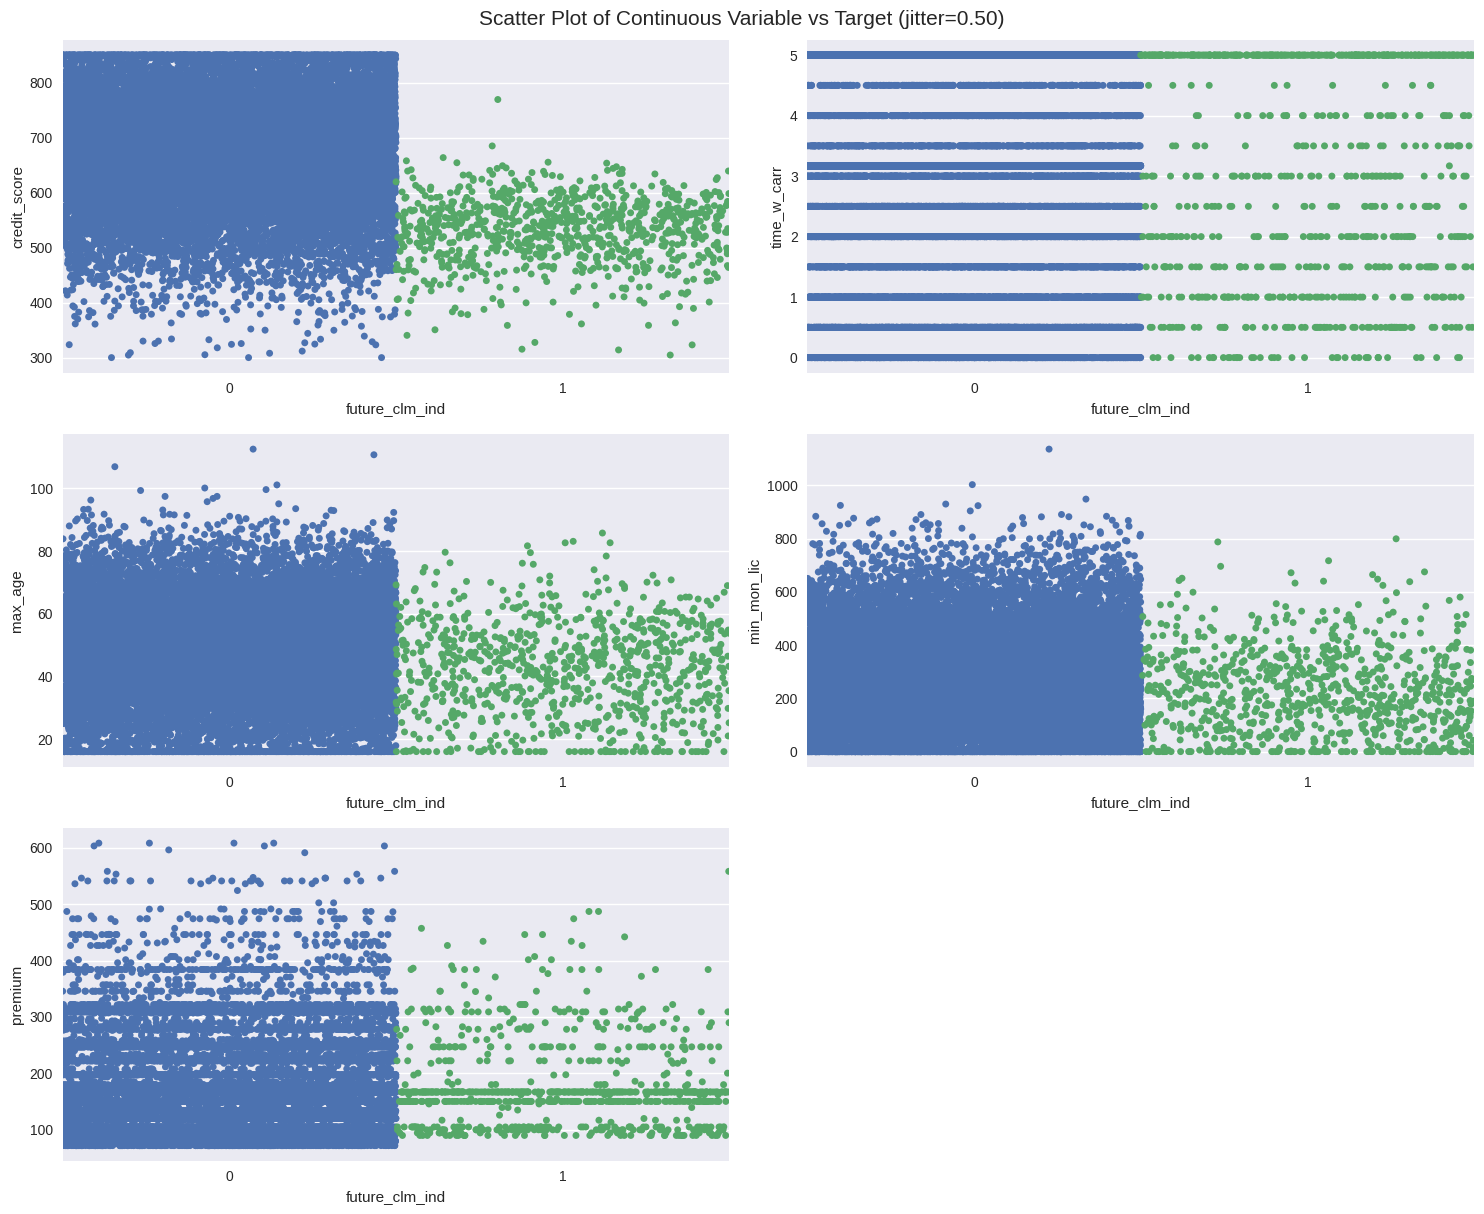

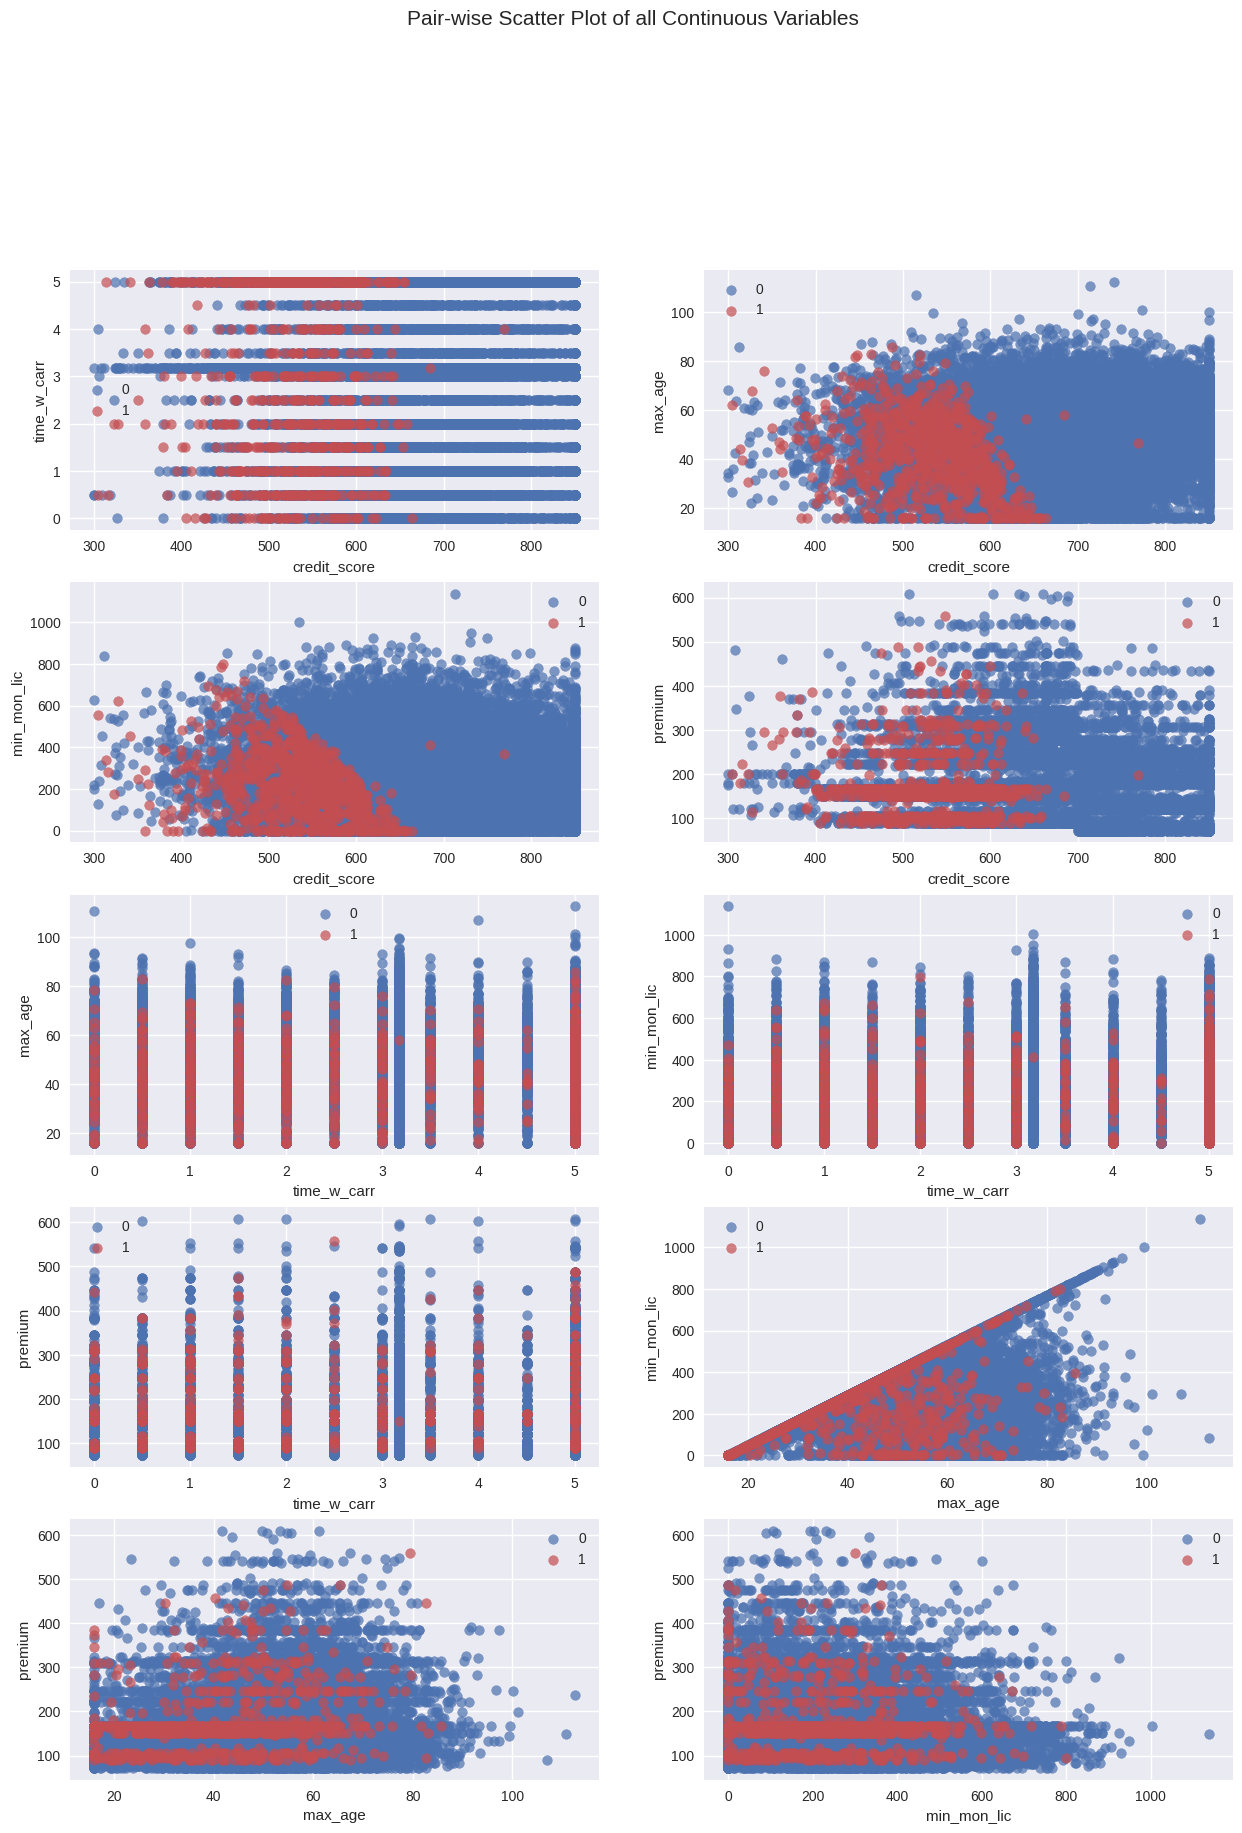

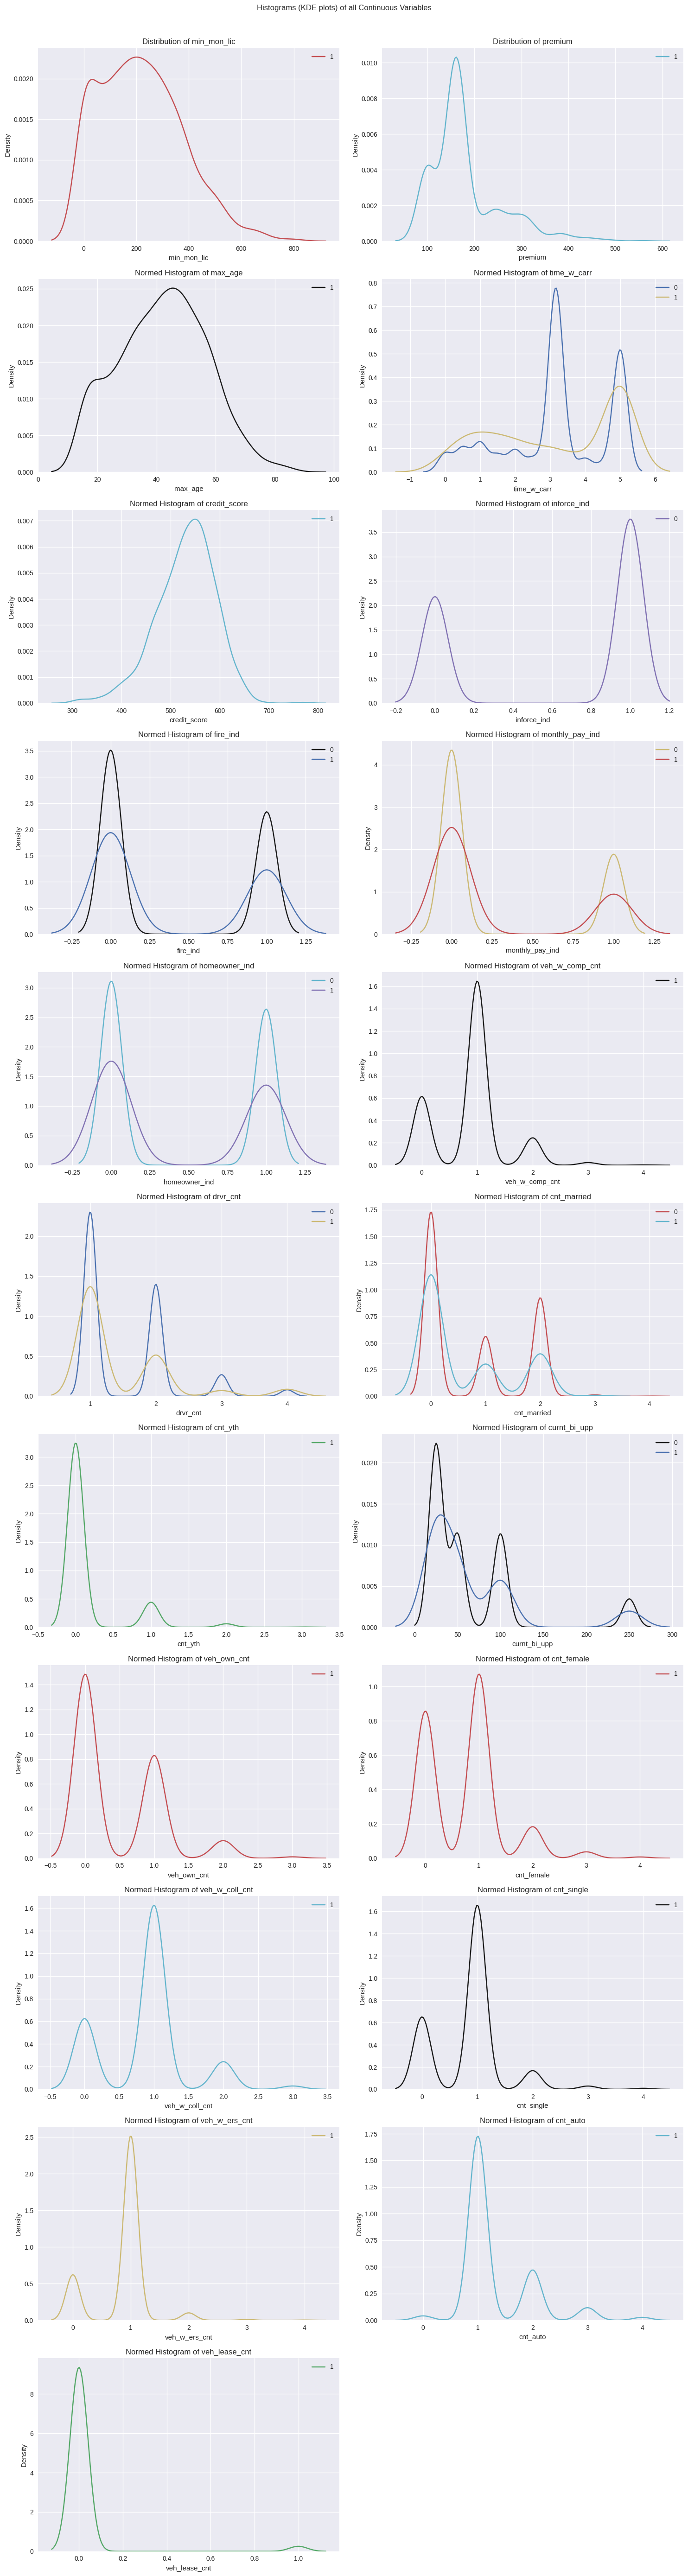

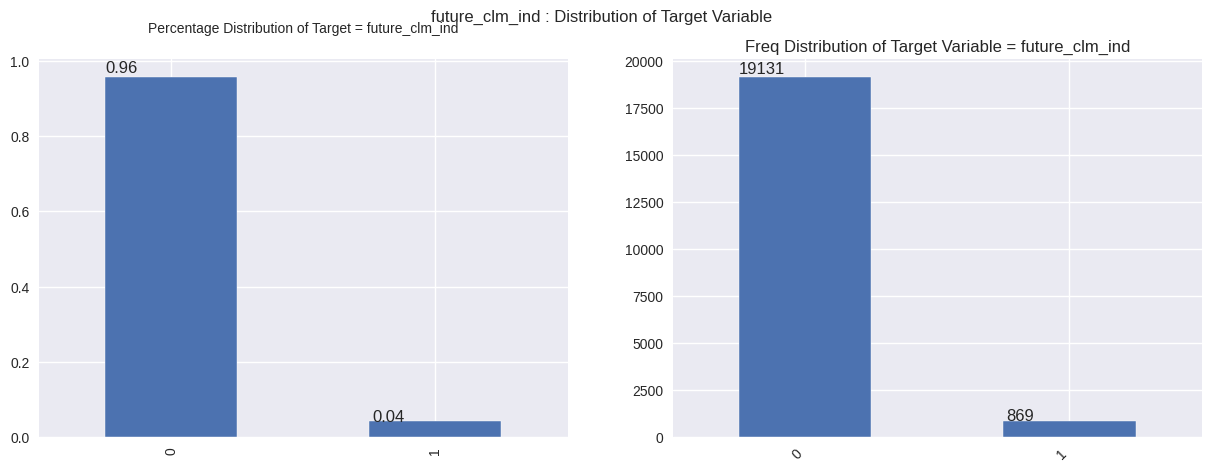

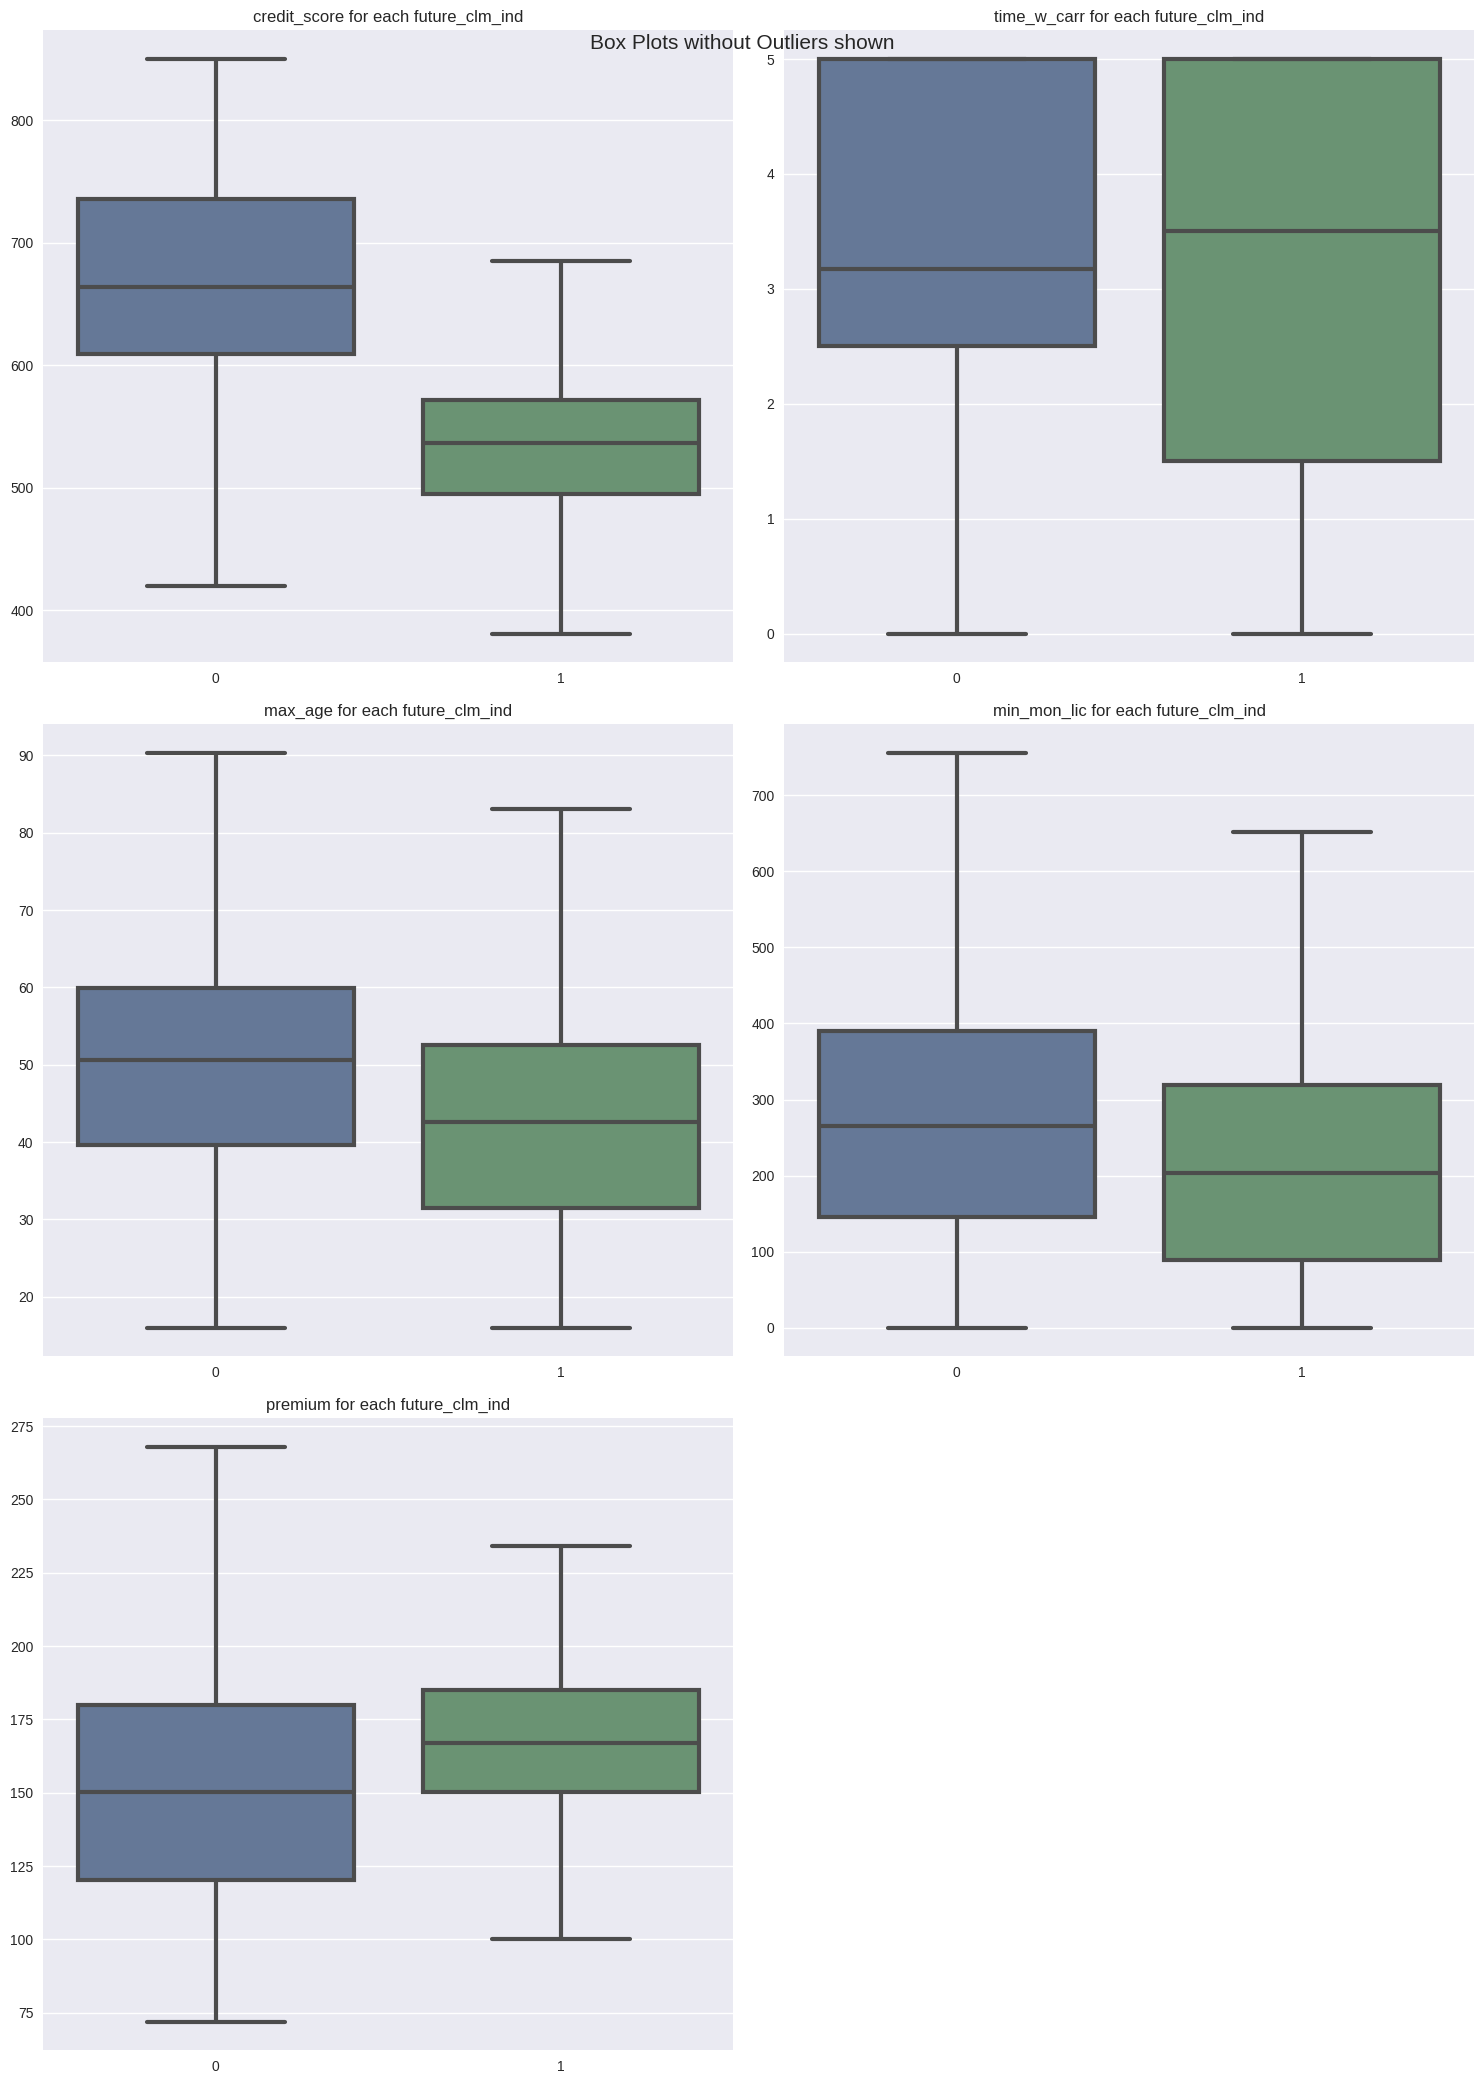

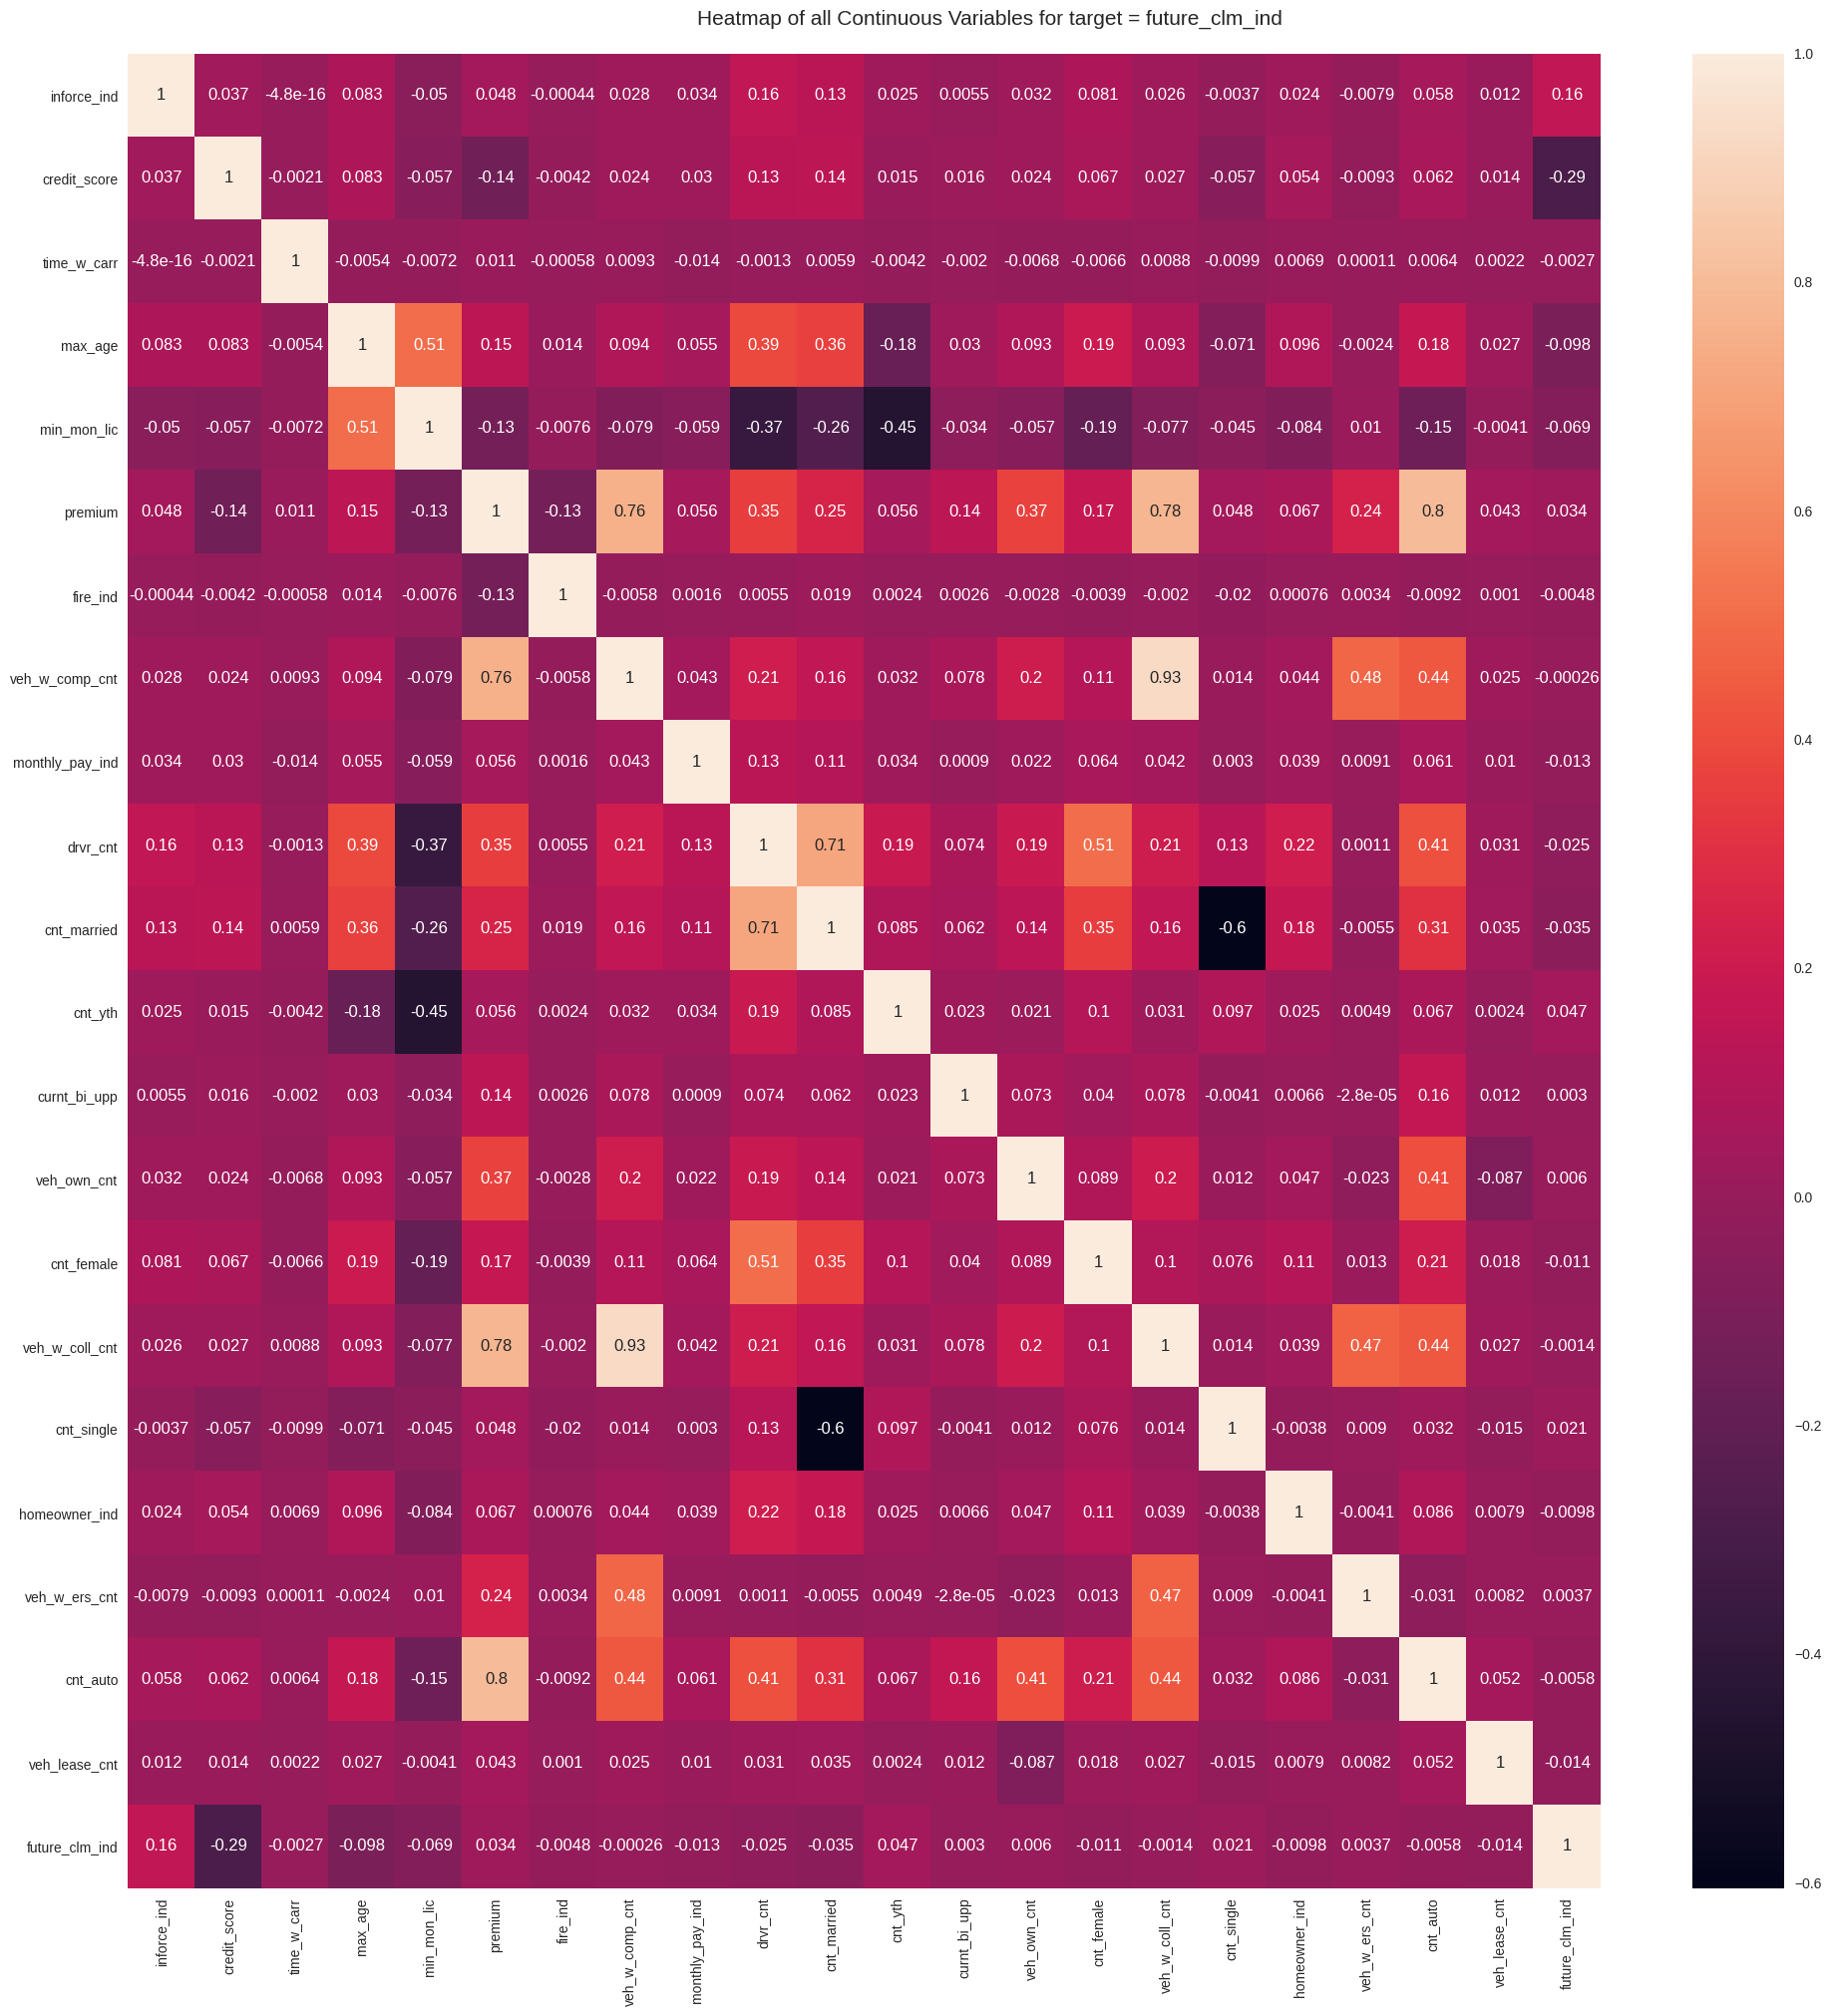

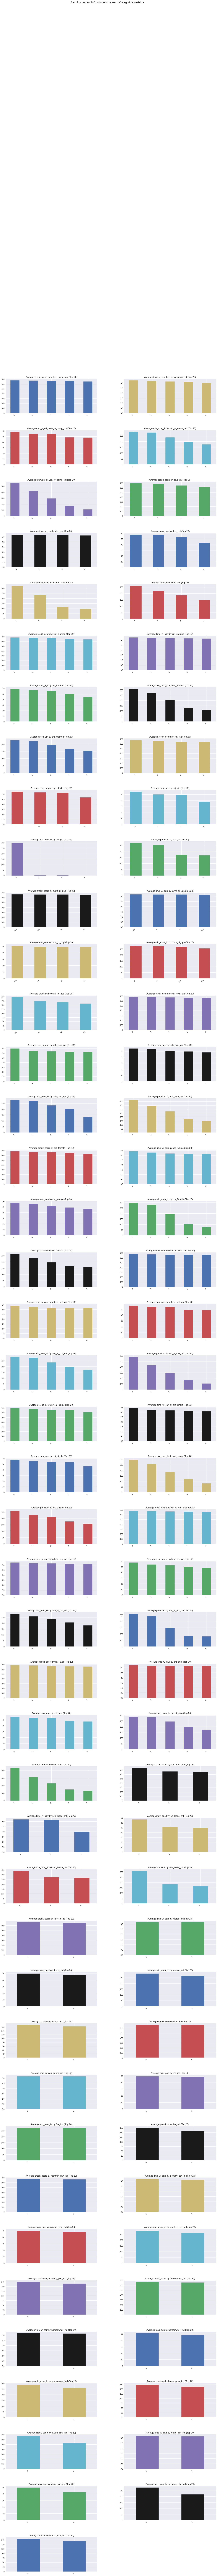

In [68]:
# Pass the datamodel and view plots
AV.AutoViz("Combind plot after feature reduction_AV",dfte=df_model,verbose=2 ,depVar='future_clm_ind')

In [69]:
# Heat map indicated 'veh_w_coll_cnt', 'veh_w_comp_cnt' have 'r'=.93.
# cnt_auto and premium has r=.8 . Dropping it from the model
df_model.drop(['veh_w_coll_cnt'], axis=1, inplace=True)

In [70]:
# cnt_auto and premium has r=.8 as per heat map shown with autoviz package. Dropping it from the model
df_model.drop(['cnt_auto'], axis=1, inplace=True)

In [71]:
df_model.dtypes # check final feature lists

drvr_cnt              int64
min_age             float64
max_age             float64
min_mon_lic         float64
max_mon_lic         float64
cnt_yth               int64
cnt_female            int64
cnt_male              int64
cnt_married           int64
cnt_single            int64
cnt_mtrcyc            int64
cnt_majr_viol         int64
cnt_minr_viol         int64
cnt_lic_susp          int64
time_w_carr         float64
inforce_ind           int64
fire_ind              int64
homeowner_ind         int64
veh_lease_cnt         int64
veh_own_cnt           int64
monthly_pay_ind       int64
veh_w_comp_cnt        int64
veh_w_ers_cnt         int64
curnt_bi_upp          int64
credit_score        float64
premium             float64
atf_claim_no        float64
Not_atf_claim_no    float64
future_clm_ind        int64
dtype: object

EDA: Final heat map using seaborn

In [72]:
# Generate new dataframe for heat map only
df_model1=df_model.corr().round(3)
df_model1.describe

<bound method NDFrame.describe of                   drvr_cnt  min_age  ...  Not_atf_claim_no  future_clm_ind
drvr_cnt             1.000   -0.371  ...            -0.006          -0.025
min_age             -0.371    1.000  ...             0.000          -0.068
max_age              0.391    0.507  ...            -0.006          -0.098
min_mon_lic         -0.369    0.998  ...             0.000          -0.069
max_mon_lic          0.397    0.498  ...            -0.006          -0.098
cnt_yth              0.191   -0.452  ...            -0.007           0.047
cnt_female           0.507   -0.192  ...            -0.001          -0.011
cnt_male             0.491   -0.178  ...            -0.005          -0.015
cnt_married          0.713   -0.266  ...            -0.001          -0.035
cnt_single           0.127   -0.045  ...            -0.006           0.021
cnt_mtrcyc           0.025   -0.009  ...            -0.004          -0.008
cnt_majr_viol        0.009   -0.002  ...             0.004        

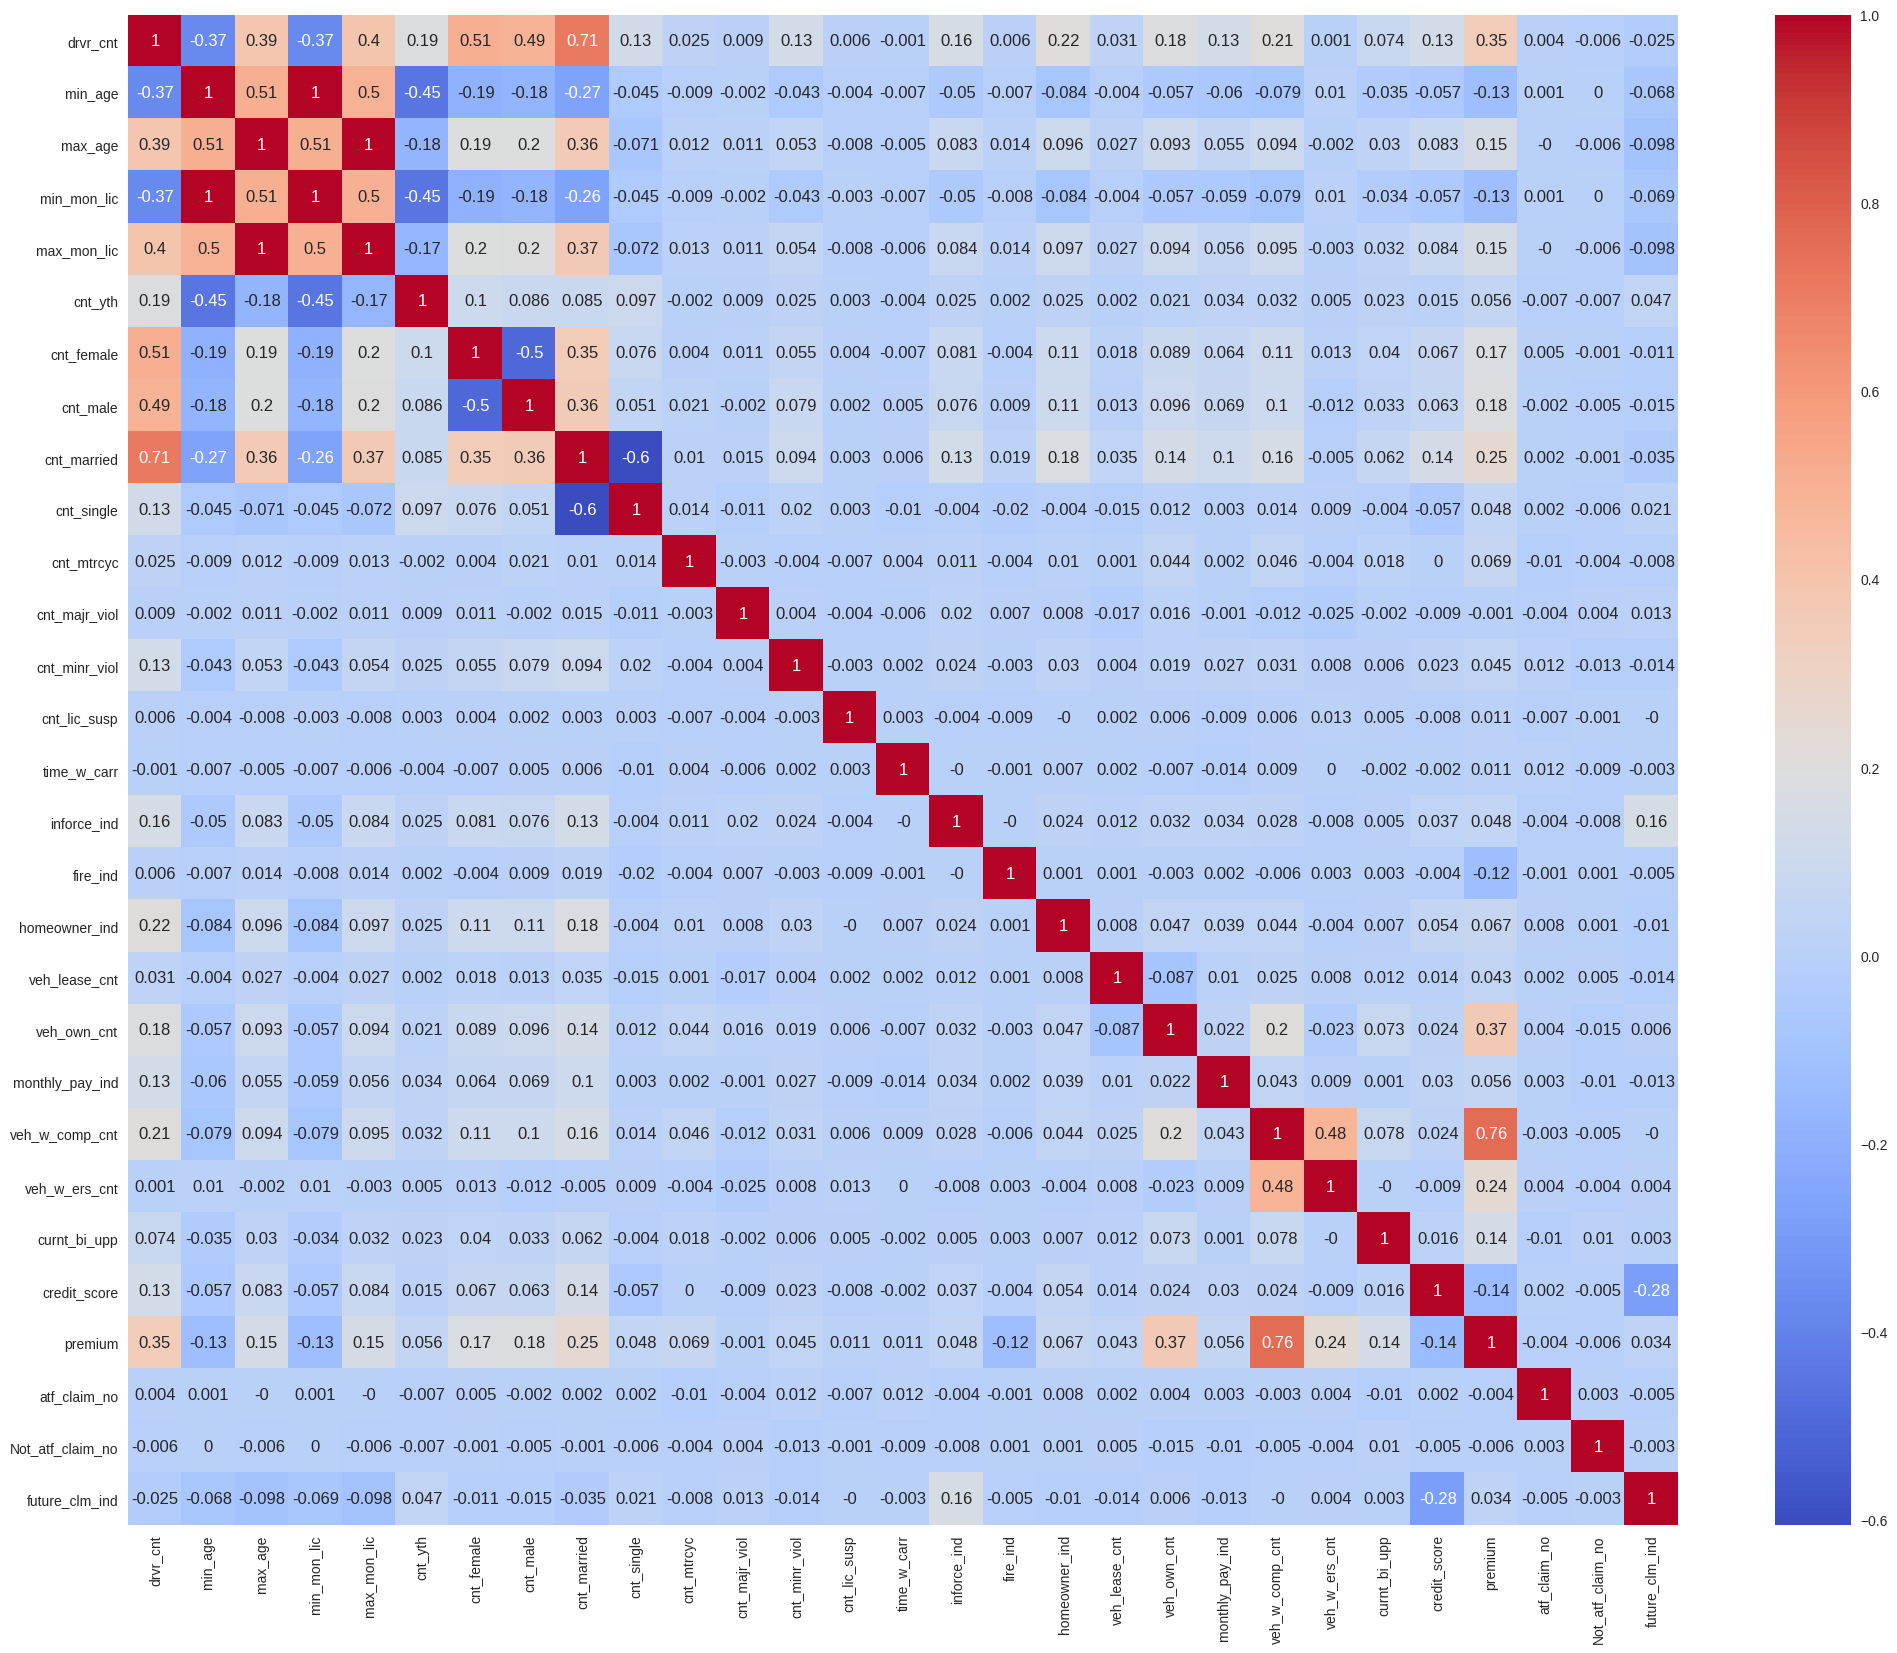

In [73]:
plt.figure(figsize=(25,20))  # Draw the figure
sns.heatmap(df_model1,cmap='coolwarm',annot=True)
plt.show()

# Step 5: Build predictive model using ML algorithms: Use PyCaret

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially and makes you more productive.

---
PyCaret is an alternate low-code library that can be used to replace hundreds of lines of code with few words only. This makes experiments exponentially fast and efficient. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and many more.


In [ ]:
# Install Pycaret AutoML package
!pip install Pycaret 

In [75]:
# Import regression and classification libraries from pycaret packge
from pycaret.classification import *
#from pycaret.regression import *


In [76]:
# check data model colums to make sure thy match
df_model.columns

Index(['drvr_cnt', 'min_age', 'max_age', 'min_mon_lic', 'max_mon_lic',
       'cnt_yth', 'cnt_female', 'cnt_male', 'cnt_married', 'cnt_single',
       'cnt_mtrcyc', 'cnt_majr_viol', 'cnt_minr_viol', 'cnt_lic_susp',
       'time_w_carr', 'inforce_ind', 'fire_ind', 'homeowner_ind',
       'veh_lease_cnt', 'veh_own_cnt', 'monthly_pay_ind', 'veh_w_comp_cnt',
       'veh_w_ers_cnt', 'curnt_bi_upp', 'credit_score', 'premium',
       'atf_claim_no', 'Not_atf_claim_no', 'future_clm_ind'],
      dtype='object')

In [ ]:
# Making sure no null or empty values are in any columns
df_model.isnull().sum()


In [78]:
# Export final data to file
df_model.to_csv('\Final input datafile for claim prediction.csv')

In [126]:
# seeting up cat and numeric cols.PyCaret often put num as cat cols
Num_cols=['drvr_cnt', 'min_age', 'max_age', 'min_mon_lic', 'max_mon_lic',
       'cnt_yth', 'cnt_female', 'cnt_male', 'cnt_married', 'cnt_single',
       'cnt_mtrcyc', 'cnt_majr_viol', 'cnt_minr_viol', 'cnt_lic_susp',
       'time_w_carr', 'veh_lease_cnt', 'veh_own_cnt', 'veh_w_comp_cnt',
       'veh_w_ers_cnt', 'credit_score', 'premium',
       'atf_claim_no', 'Not_atf_claim_no']  
#bin_cols= ['curnt_bi_upp'] #  1 bin numeric 
Cat_Cols= ['inforce_ind', 'fire_ind', 'homeowner_ind', 'monthly_pay_ind','curnt_bi_upp'] # 4 cat cols

## Setup predictive model with pycaret.

In [ ]:
claim_model=setup(df_model, target='future_clm_ind', numeric_features=Num_cols, categorical_features=Cat_Cols,
                        fix_imbalance=True,
                        train_size=.7)               
#Ensure your scikit-learn version is 0.23.2 (not the latest 0.24). upgrade of pyCaret create AttributeError: 'Make_Time_Features' object has no attribute 'list_of_features'                                     



In [134]:
# Compare models to find best one based on high accuracy and recall
compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.9519  0.9334  0.0730  0.3453   
rf               Random Forest Classifier    0.9514  0.9440  0.0873  0.3438   
lightgbm  Light Gradient Boosting Machine    0.9479  0.9490  0.1857  0.3568   
gbc          Gradient Boosting Classifier    0.9397  0.9470  0.3111  0.3274   
ada                  Ada Boost Classifier    0.9374  0.9397  0.3889  0.3350   
dt               Decision Tree Classifier    0.9346  0.6398  0.3159  0.2903   
lr                    Logistic Regression    0.8922  0.9514  0.9825  0.2928   
knn                K Neighbors Classifier    0.8745  0.8390  0.6444  0.2100   
lda          Linear Discriminant Analysis    0.8262  0.9475  0.9968  0.2055   
ridge                    Ridge Classifier    0.8261  0.0000  0.9968  0.2055   
svm                   SVM - Linear Kernel    0.7830  0.0000  0.8206  0.1966   
nb                            Naive Bayes    0.7121  0.8808  0.8714  0.1224   
qda       Quadratic Discriminant Analysis    0.4717  0.7206  0.9286  0.0791   

              F1   Kappa     MCC  TT (Sec)  
et        0.1180  0.1042  0.1390     1.544  
rf        0.1377  0.1219  0.1533     2.298  
lightgbm  0.2422  0.2181  0.2316     0.540  
gbc       0.3171  0.2858  0.2868     5.369  
ada       0.3593  0.3267  0.3280     1.268  
dt        0.3007  0.2667  0.2678     0.179  
lr        0.4510  0.4101  0.5040     2.193  
knn       0.3166  0.2669  0.3184     0.227  
lda       0.3407  0.2876  0.4091     0.141  
ridge     0.3406  0.2875  0.4090     0.051  
svm       0.2784  0.2241  0.3190     0.517  
nb        0.2146  0.1473  0.2561     0.051  
qda       0.1449  0.0676  0.1615     0.075

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6873, verbose=0,
                     warm_start=False)

**Final model selection: Logistic Regression**

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - 
Recall = TP/TP+FN.

 F1 score - F1 Score is the weighted average of Precision and Recall.


Precision: calculates the accuracy for the minority class. It is calculated as the ratio of correctly predicted positive examples divided by the total number of positive examples that were predicted.

Precision= TP/(TP+FP)

In [135]:
# Create model based on recall and accuracy criteria. Selected Logistic Regression for this with acuuracy is 88%  and recall 
claim_model=create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8914  0.9512  0.9841  0.2911  0.4493  0.4082  0.5028
1       0.9000  0.9630  1.0000  0.3103  0.4737  0.4349  0.5271
2       0.8907  0.9429  0.9841  0.2897  0.4477  0.4064  0.5014
3       0.8914  0.9430  0.9524  0.2871  0.4412  0.3997  0.4892
4       0.8786  0.9434  0.9841  0.2684  0.4218  0.3778  0.4790
5       0.8907  0.9503  0.9683  0.2877  0.4436  0.4022  0.4946
6       0.8964  0.9501  0.9841  0.3010  0.4610  0.4211  0.5129
7       0.9000  0.9567  1.0000  0.3103  0.4737  0.4349  0.5271
8       0.8936  0.9547  0.9683  0.2933  0.4502  0.4094  0.5003
9       0.8892  0.9590  1.0000  0.2890  0.4484  0.4070  0.5054
Mean    0.8922  0.9514  0.9825  0.2928  0.4510  0.4101  0.5040
SD      0.0058  0.0066  0.0150  0.0117  0.0147  0.0161  0.0145

In [136]:
# Model tuning to increase precision of lr model. Precision is 29% on minority positive class. This is type 1 error , means a lot of false positive .
tuned_lr=tune_model(claim_model,optimize='precision')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8943  0.9515  0.9841  0.2967  0.4559  0.4155  0.5085
1       0.9014  0.9628  1.0000  0.3134  0.4773  0.4388  0.5302
2       0.8921  0.9428  0.9841  0.2925  0.4509  0.4100  0.5042
3       0.8907  0.9429  0.9524  0.2857  0.4396  0.3979  0.4878
4       0.8814  0.9432  0.9841  0.2731  0.4276  0.3842  0.4841
5       0.8907  0.9507  0.9683  0.2877  0.4436  0.4022  0.4946
6       0.8986  0.9504  1.0000  0.3073  0.4701  0.4310  0.5241
7       0.9014  0.9567  1.0000  0.3134  0.4773  0.4388  0.5302
8       0.8936  0.9547  0.9683  0.2933  0.4502  0.4094  0.5003
9       0.8899  0.9591  1.0000  0.2903  0.4500  0.4087  0.5068
Mean    0.8934  0.9515  0.9841  0.2953  0.4542  0.4136  0.5071
SD      0.0057  0.0067  0.0159  0.0122  0.0155  0.0170  0.0157

In [ ]:
# Evaluate the  model with plots
evaluate_model(claim_model)

**Below model with fix imbalance= False.**
with pyCaret.
 This is not recommended as response variable is highly impalanced towards future claim indicator.

In [ ]:
claim_model=setup(df_model, target='future_clm_ind', numeric_features=Num_cols, categorical_features=Cat_Cols,imputation_type='iterative',
                        fix_imbalance=False,
                        train_size=.7)               
#Ensure your scikit-learn version is 0.23.2 (not the latest 0.24). upgrade of pyCaret create AttributeError: 'Make_Time_Features' object has no attribute 'list_of_features'                                     



In [88]:
compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
ridge                    Ridge Classifier    0.9564  0.0000  0.0000  0.0000   
gbc          Gradient Boosting Classifier    0.9550  0.9506  0.0443  0.4095   
rf               Random Forest Classifier    0.9543  0.9480  0.0344  0.2949   
et                 Extra Trees Classifier    0.9541  0.9372  0.0230  0.2581   
lda          Linear Discriminant Analysis    0.9530  0.9462  0.0803  0.3306   
lr                    Logistic Regression    0.9522  0.9510  0.0918  0.3214   
knn                K Neighbors Classifier    0.9502  0.7612  0.0557  0.2223   
lightgbm  Light Gradient Boosting Machine    0.9499  0.9514  0.1426  0.3260   
ada                  Ada Boost Classifier    0.9492  0.9454  0.1459  0.3224   
svm                   SVM - Linear Kernel    0.9448  0.0000  0.0787  0.1055   
dt               Decision Tree Classifier    0.9386  0.6362  0.3049  0.3023   
nb                            Naive Bayes    0.7821  0.9107  0.9344  0.1597   
qda       Quadratic Discriminant Analysis    0.4656  0.7592  0.8934  0.0616   

              F1   Kappa     MCC  TT (Sec)  
ridge     0.0000  0.0000  0.0000     0.033  
gbc       0.0776  0.0691  0.1149     1.628  
rf        0.0611  0.0525  0.0869     0.997  
et        0.0415  0.0339  0.0630     0.867  
lda       0.1285  0.1137  0.1450     0.069  
lr        0.1408  0.1245  0.1513     1.333  
knn       0.0880  0.0718  0.0909     0.175  
lightgbm  0.1976  0.1760  0.1925     0.231  
ada       0.1990  0.1768  0.1926     0.467  
svm       0.0822  0.0663  0.0700     0.186  
dt        0.3027  0.2706  0.2711     0.063  
nb        0.2727  0.2142  0.3325     0.030  
qda       0.1153  0.0457  0.1438     0.030

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=8062,
                solver='auto', tol=0.001)

In [89]:
nofix_model=create_model('nb')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8100  0.9238  0.9672  0.1827  0.3073  0.2525  0.3731
1       0.7836  0.9333  0.9508  0.1620  0.2768  0.2187  0.3401
2       0.7800  0.9072  0.9180  0.1560  0.2667  0.2076  0.3234
3       0.7850  0.9084  0.9344  0.1610  0.2747  0.2165  0.3347
4       0.7721  0.9026  0.9016  0.1495  0.2564  0.1963  0.3097
5       0.7850  0.9316  1.0000  0.1685  0.2884  0.2311  0.3614
6       0.7629  0.8993  0.9180  0.1462  0.2523  0.1915  0.3086
7       0.7771  0.8871  0.8852  0.1504  0.2571  0.1974  0.3074
8       0.7986  0.9114  0.9344  0.1701  0.2879  0.2312  0.3478
9       0.7670  0.9022  0.9344  0.1504  0.2591  0.1989  0.3188
Mean    0.7821  0.9107  0.9344  0.1597  0.2727  0.2142  0.3325
SD      0.0134  0.0140  0.0311  0.0109  0.0169  0.0186  0.0219

In [92]:
evaluate_model(nofix_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<Figure size 800x550 with 0 Axes>